# Truck Prices
Using a linear regression, I will model the prices of used trucks.
Target: Truck sale price
Features: mileage, make, model, year of production

Process:
1. scrape the data using extract and selenium
2. parse the string with beautifulsoup
3. store data in pandas dataframe
4. fit linear regression using sklearn.linear_model, iterate model for best metrics
5. test final model on test data
6. create 5 minute presentation and paper

In [24]:
import requests
from bs4 import BeautifulSoup as bs
import time, os

Using requests library, ensure dealership site can be scraped for HTML file since sales forums like carvana, carmax, and cars.com don't allow scraping.

In [25]:
'''large used car sale sites like carvana, carmax, cars.com block scraping. individual dealer sites do not'''
#https://www.hendrickcars.com/robots.txt
url = 'https://www.hendrickcars.com/used-inventory/index.htm?normalBodyStyle=Truck&referrer=%2F&saveFacetState=true&geoZip=60601&geoRadius=0'
response = requests.get(url)
print(response.status_code)

'''code 200 means successful HTML extraction'''


200


'code 200 means successful HTML extraction'

In [26]:
'''website only loads 25 matches at a time,
need to click next at bottom. selenium will help with this.'''
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

chromedriver = "/home/jtaz/Documents/lin_reg/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

In [27]:
driver = webdriver.Chrome(chromedriver)
driver.get(url) #driver opens browser window to URL specified


/tmp/ipykernel_1754/360657133.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chromedriver)


In [66]:
'''need to scroll to the bottom of the page, pausing along the way to let all the listings load,
save page html, then click next and repeat'''
from selenium.webdriver.common.by import By

def scroll():
    element = driver.find_element(By.XPATH, "//a[@aria-label='Go to next page']")#find next page button
    driver.execute_script('window.scrollTo(0,2000)')#partial scroll
    time.sleep(3) #pause to let page load, 3 sec
    driver.execute_script('window.scrollTo(0,4000)')
    time.sleep(3)
    driver.execute_script('window.scrollTo(0,6000)')
    time.sleep(3)
    driver.execute_script('window.scrollTo(0,8000)')
    time.sleep(3)
    driver.execute_script(
    "arguments[0].scrollIntoView(false);", element)#scroll to next page button, align with bottom of screen so
    #UI banner doesn't overlap the button and prevent the click()
    time.sleep(3)#pause to let page load
        
def click_next():
    #driver.find_element_by_class_name('pagination-next').click()
    driver.find_element(By.XPATH, "//a[@aria-label='Go to next page']").click()


In [70]:
'''iterate through the web pages, scroll down, save the html, click the next page button. store in truck list'''
truck1 = []
x = 1    
while x <= 45:
    scroll()
    truck1.append(driver.page_source)
    click_next()
    time.sleep(5)
    x += 1

In [64]:
'''check to make sure the above code worked and did not pull the same page repeatedly'''
count = 0
while count < len(soups[0]):
    same = True
    if soups[0][count]!=soups[1][count]:
        same = False
        print(same)
        break
    count += 1
        

False


In [72]:
'''sometimes the page loaded an add or customer assistance widget causing the .click() to fail.
merge multiple pulls into one variable'''
truck_lst = truck+truck1
len(truck_lst)

50

In [73]:
import pickle

#with open('truck_lst.pickle', 'wb') as f:
#    pickle.dump(truck_lst, f)

In [74]:
driver.close()

## Parse HTML string
I used selenium to pull 50 pages of truck search results from a dealership website and stored them in a list called truck. Now I will use beautifulsoup to parse the string files and extract the relevant information and store in a pandas dataframe.

In [75]:
import pickle

with open('truck_lst.pickle', 'rb') as g:
    tsoup = pickle.load(g)

In [76]:
'''create soup object for one html page to test parsing code'''
truck_soup = bs(tsoup[0], 'html5lib')

In [78]:
'''extract year make and model from each car listing in the 1 test page'''
year_make_model = []

for div in truck_soup.find_all('div', class_='vehicle-card-details-container'):
    year_make_model.append(div.find('a').text)
    #print('info:' + div.find('a').text)

In [83]:
'''iterate the year, make, model parser across all 50 html strings'''
ymk = []

for pg in tsoup:
    trk_sp = bs(pg, 'html5lib')
    for div in trk_sp.find_all('div', class_='vehicle-card-details-container'):
        ymk.append(div.find('a').text)

In [87]:
'''extract the truck price from all listings'''
price = []

for pg in tsoup:
    trk_sp = bs(pg, 'html5lib')
    for div in trk_sp.find_all('div', class_='vehicle-card-details-container'):
        price.append(div.find('span').text)

In [89]:
'''extract the odom readings from all car listings'''
odom = []

for pg in tsoup:
    trk_sp = bs(pg, 'html5lib')
    for li in trk_sp.find_all('li', class_='odometer'):
        odom.append(li.text)

In [90]:
'''extract the dealership type'''
acct_name = []

for pg in tsoup:
    trk_sp = bs(pg, 'html5lib')
    for li in trk_sp.find_all('li', class_='accountName'):
        acct_name.append(li.text)

In [91]:
'''check to ensure correct info pulled into each list, and see what cleaning needs to be done'''
print(price[0])
print(ymk[0])
print(odom[0])
print(acct_name[0])

$21,996
2014 Ram 1500 Tradesman
Mileage: 83,421 miles 
Location: Hendrick Lexus Kansas City North 


In [92]:
'''clean price by removing dollar sign and comma'''
cl_price = []
for val in price:
    new_price = ''
    for char in val:
        if char != '$' and char != ',':
            new_price += char
    cl_price.append(new_price)
    
print(cl_price[0])

21996


In [93]:
'''clean mileage by removing word, miles, and comma'''
cl_odom = []
for val in odom:
    new_odom = ''
    for char in val:
        if char.isnumeric() == True:
            new_odom += char
    cl_odom.append(new_odom)
    
print(cl_odom[0])

83421


In [99]:
'''isolate year, make, and model'''
year = []
make = []
model = []

for val in ymk:
    splt_ymk = val.split()
    year.append(splt_ymk[0])
    make.append(splt_ymk[1])
    model.append(' '.join(splt_ymk[2:]))

print('year: ' + year[0], 'make: '+make[0],'model: '+model[0])


year: 2014 make: Ram model: 1500 Tradesman


In [101]:
'''get unique make values in preparation for dummy variable'''
import numpy as np

uniq_makes = np.unique(make)
print(uniq_makes)

['Chevrolet' 'Dodge' 'Ford' 'GMC' 'Honda' 'Hyundai' 'Jeep' 'Nissan' 'Ram'
 'Toyota']


In [102]:
'''check to see if all lists are the same length prior to zipping'''
print(len(year))
print(len(make))
print(len(model))
print(len(cl_price))
print(len(cl_odom))

1350
1350
1350
1350
1350


In [103]:
'''zip lists to get list of tuples where each row is one tuple'''
zipped = zip(year, make, model, cl_odom, cl_price)
zip_lst = list(zipped)

In [104]:
import pandas as pd

In [120]:
df = pd.DataFrame(zip_lst, columns = ['Year', 'Make', 'Model', 'Mileage', 'Price'])

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     1350 non-null   object
 1   Make     1350 non-null   object
 2   Model    1350 non-null   object
 3   Mileage  1350 non-null   object
 4   Price    1350 non-null   object
dtypes: object(5)
memory usage: 52.9+ KB


In [122]:
df.head()

,Year,Make,Model,Mileage,Price
0,2014,Ram,1500 Tradesman,83421,21996
1,2018,Chevrolet,Silverado 2500HD LTZ,87912,59995
2,2020,Chevrolet,Silverado 1500 LT,38333,39857
3,2020,GMC,Sierra 1500 Denali,13797,62471
4,2019,GMC,Sierra 1500 Denali,23475,69957


In [127]:
'''make number columns int instead of object'''
df1 = pd.DataFrame(data = df.astype({'Year':'int64', 'Mileage':'int64', 'Price':'int64'}))

In [131]:
df1['Dodge'] = ((df1['Make'] == 'Dodge'))
df1['Ford'] = ((df1['Make'] == 'Ford'))
df1['GMC'] = ((df1['Make'] == 'GMC'))
df1['Honda'] = ((df1['Make'] == 'Honda'))
df1['Hyundai'] = ((df1['Make'] == 'Hyundai'))
df1['Jeep'] = ((df1['Make'] == 'Jeep'))
df1['Nissan'] = ((df1['Make'] == 'Nissan'))
df1['Ram'] = ((df1['Make'] == 'Ram'))
df1['Toyota'] = ((df1['Make'] == 'Toyota'))
df1.sample(10)

,Year,Make,Model,Mileage,Price,Dodge,Ford,GMC,Honda,Hyundai,Jeep,Nissan,Ram,Toyota
1249,2016,Chevrolet,Colorado 2WD Z71,122213,22938,False,False,False,False,False,False,False,False,False
888,2019,Toyota,Tacoma 4WD TRD Sport,40794,36500,False,False,False,False,False,False,False,False,True
405,2020,Chevrolet,Silverado 1500 RST,54213,50998,False,False,False,False,False,False,False,False,False
937,2019,Toyota,Tacoma 4WD SR5,22130,37321,False,False,False,False,False,False,False,False,True
625,2016,Chevrolet,Silverado 3500HD LTZ,135559,49982,False,False,False,False,False,False,False,False,False
958,2021,Jeep,Gladiator High Altitude,7708,53889,False,False,False,False,False,True,False,False,False
912,2020,GMC,Sierra 2500HD AT4,23262,77171,False,False,True,False,False,False,False,False,False
36,2016,Ford,F-150 XLT,97985,29588,False,True,False,False,False,False,False,False,False
767,2020,Ford,F-150 XL,28433,42500,False,True,False,False,False,False,False,False,False
462,2020,Chevrolet,Silverado 1500 LT,41672,36994,False,False,False,False,False,False,False,False,False


In [133]:
'''create dummy variables for categorical make column. could have used pd.get_dummies(df1['Make'],drop_first=True)'''
'''chevrolet is the dropped column, the default to prevent multi-collinearity issues'''
df2 = pd.DataFrame(data = df1.astype({'Dodge':'int64', 'Ford':'int64', 'GMC':'int64', 'Honda':'int64',
                                      'Hyundai':'int64', 'Jeep':'int64', 'Nissan':'int64', 'Ram':'int64',
                                      'Toyota':'int64'}))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     1350 non-null   int64 
 1   Make     1350 non-null   object
 2   Model    1350 non-null   object
 3   Mileage  1350 non-null   int64 
 4   Price    1350 non-null   int64 
 5   Dodge    1350 non-null   int64 
 6   Ford     1350 non-null   int64 
 7   GMC      1350 non-null   int64 
 8   Honda    1350 non-null   int64 
 9   Hyundai  1350 non-null   int64 
 10  Jeep     1350 non-null   int64 
 11  Nissan   1350 non-null   int64 
 12  Ram      1350 non-null   int64 
 13  Toyota   1350 non-null   int64 
dtypes: int64(12), object(2)
memory usage: 147.8+ KB


In [135]:
df2.drop('Make',axis=1, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     1350 non-null   int64 
 1   Model    1350 non-null   object
 2   Mileage  1350 non-null   int64 
 3   Price    1350 non-null   int64 
 4   Dodge    1350 non-null   int64 
 5   Ford     1350 non-null   int64 
 6   GMC      1350 non-null   int64 
 7   Honda    1350 non-null   int64 
 8   Hyundai  1350 non-null   int64 
 9   Jeep     1350 non-null   int64 
 10  Nissan   1350 non-null   int64 
 11  Ram      1350 non-null   int64 
 12  Toyota   1350 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 137.2+ KB


In [139]:
#with open('dataframe.pickle', 'wb') as f:
#    pickle.dump(df2, f)

## Linear Regression Model
The data has been successfully scraped and cleaned from the dealership website. Next step is to begin modeling.

### Load Data

In [2]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pickle

with open('dataframe.pickle', 'rb') as g:
    df = pickle.load(g)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     1350 non-null   int64 
 1   Model    1350 non-null   object
 2   Mileage  1350 non-null   int64 
 3   Price    1350 non-null   int64 
 4   Dodge    1350 non-null   int64 
 5   Ford     1350 non-null   int64 
 6   GMC      1350 non-null   int64 
 7   Honda    1350 non-null   int64 
 8   Hyundai  1350 non-null   int64 
 9   Jeep     1350 non-null   int64 
 10  Nissan   1350 non-null   int64 
 11  Ram      1350 non-null   int64 
 12  Toyota   1350 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 137.2+ KB


## Feature Engineering
I am going to switch the vehicle year to years old from 2022. This will change the values to the same magnitude as the dummy variables. Additionally, I will apply a standard scaler to all the variables and remodel. No missing variables or time data to take into consideration. Use a pair plot to assess relationships between variables as well as to evaluate if polynomial linear regression is an option.

In [5]:
'''replace year with years old so value is same magnitude as dummy variables'''
df['Years_Old'] = 2022 - df['Year']
df['Years_Old'].head()

0    8
1    4
2    2
3    2
4    3
Name: Years_Old, dtype: int64

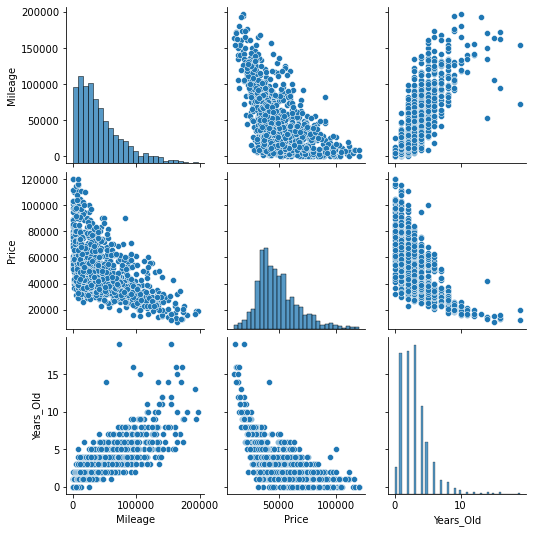

In [7]:
'''pair plot to compare variables'''
import seaborn as sns
import statsmodels.api as sm

sns.pairplot(df.drop(columns=['Model', 'Year', 'Dodge', 'Ford','GMC','Honda','Hyundai','Jeep','Nissan','Ram','Toyota']))

plt.savefig('pairplot.jpg')

### Split data into Train & Test

In [11]:
from sklearn.model_selection import train_test_split
x = df.drop(columns=['Price', 'Model']) #drop jeep and dodge because they're p-values below 0.05
y = df['Price']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state = 21) #.2 = 20% res for test

### Split into Multiple Folds for Cross Validation
I only scraped 1300 rows of data, small datasets benefit from cross validation.

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, #5 groups
          shuffle = True,#randomizes order of rows before split
          random_state=21) #save state for repeatability

### Baseline: Linear Regression

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

bl_lin_reg = LinearRegression()

baseline_score = cross_val_score(bl_lin_reg, x_train, y_train, cv=kf, scoring='r2')
print(baseline_score)
print("Linear Reg Mean Score: ", np.mean(baseline_score))

bl_lin_reg_fit = bl_lin_reg.fit(x_train, y_train)

import statsmodels.api as sm

x_train2 = sm.add_constant(x_train)
sm_bl_lin_reg = sm.OLS(y_train, x_train2)
sm_bl_lin_reg_fit = sm_bl_lin_reg.fit()
sum_latex = sm_bl_lin_reg_fit.summary().as_latex()

with open('latex.txt','w') as text_file:
    text_file.write(sum_latex)

[0.44317402 0.39125662 0.43247868 0.42050969 0.45550769]
Linear Reg Mean Score:  0.42858533863148923


### Evaluate Model

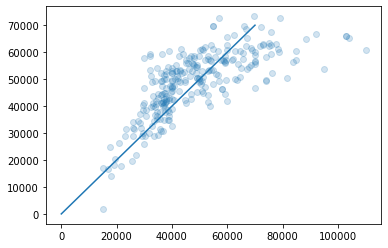

In [16]:
'''compare fitted data to actual data'''
y_test_pred = bl_lin_reg_fit.predict(x_test)

plt.scatter(y_test, y_test_pred, alpha=0.2)
plt.plot([0,70000],[0,70000])

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(bl_lin_reg_fit.intercept_)
print(bl_lin_reg_fit.coef_)

bl_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE: ' + str(bl_rmse))

-2631210.212536516
[ 1.33143477e+03 -1.31644945e-01  1.17572931e+04  6.57882221e+03
  1.24363229e+04 -1.00246863e+04  1.81898940e-12  9.99443844e+02
 -8.20111591e+03  5.16837255e+03 -5.15569539e+03 -1.33143477e+03]
RMSE: 11701.238305660887


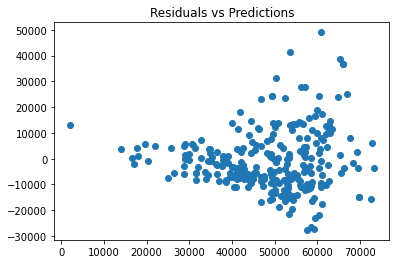

In [19]:
'''plot residuals vs predicted'''
lin_reg_residuals = y_test - y_test_pred

plt.scatter(y_test_pred, lin_reg_residuals)
plt.title("Residuals vs Predictions")
plt.savefig('bl_residuals.jpg')

Residual plot should look like noise, this model likely has a specification issue.

## Linear Regression with Standard Scaler for Features:

In [96]:
'''standard scaling across features'''
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(x_train)
x_tr_sc = std.transform(x_train)
x_te_sc = std.transform(x_test)

lm_scaler = LinearRegression()
lm_scaler_score = cross_val_score(lm_scaler, x_tr, y_train, cv=kf, scoring='r2') #estimator, features, target vars
print('R2 for Linear Model with standard scaler: ' + str(np.round(np.mean(lm_scaler_score),2)))

lm_scaler_fit = lm_scaler.fit(x_tr_sc, y_train)

R2 for Linear Model with standard scaler: 0.43


### Evaluate Standard Scaler

In [91]:
from sklearn.metrics import mean_squared_error

std_scl_y_pred = lm_scaler_fit.predict(x_te_sc)

std_scl_rmse = np.sqrt(mean_squared_error(y_test, std_scl_y_pred))
print('RMSE: ' + str(std_scl_rmse))

RMSE: 11704.103727994332


## Elastic Net
To adjust model to overcome under and overfitting due to bias and variance, I will add the ElasticNet regularized regression method.

In [98]:
from sklearn.linear_model import ElasticNetCV

alphas = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_rats = [.1, .5, .7, .9, .95, .99, .1, .15, .2, .25, .3, .5, .75]

enet_model = ElasticNetCV(alphas = alphas,
                         l1_ratio = l1_rats,
                         cv = kf)
enet_model_fit = enet_model.fit(x_train, y_train)
print('Elastic Net R^2 = ' + str(enet_model_fit.score(x_train, y_train)))

Elastic Net R^2 = 0.44469370764903304


### Evaluate Elastic Net Model

In [99]:
from sklearn.metrics import mean_squared_error

enet_y_pred = enet_model_fit.predict(x_test)

enet_rmse = np.sqrt(mean_squared_error(y_test, enet_y_pred))
print('RMSE: ' + str(enet_rmse))

RMSE: 11692.565436495488


## Polynomial Linear Regression

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False) #create scikit polynomial feature object
poly_features = poly.fit_transform(x) #store polynomial object array in var
poly_x_train, poly_x_test, poly_y_train, poly_y_test = train_test_split(poly_features, y, test_size=0.2, random_state=21)

poly_reg_m = LinearRegression()
poly_reg_fit = poly_reg_m.fit(poly_x_train,poly_y_train)
print('Poly R^2= ' + str(poly_reg_m.score(poly_x_train,poly_y_train)))


Poly R^2= 0.503625514439383


### Evaluate Polynomial Regression

In [25]:
from sklearn.metrics import mean_squared_error

poly_reg_y_pred = poly_reg_fit.predict(poly_x_test)

poly_reg_rmse = np.sqrt(mean_squared_error(poly_y_test, poly_reg_y_pred))
print('RMSE: ' + str(poly_reg_rmse))

RMSE: 11251.030823142704


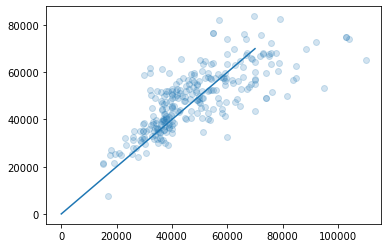

In [27]:
'''compare fitted data to actual data'''

plt.scatter(poly_y_test, poly_reg_y_pred, alpha=0.2)
plt.plot([0,70000],[0,70000])
plt.savefig('poly_resid.jpg')